# Imports

In [7]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import os
import matplotlib.pyplot as plt
from typing import List


# Load datasets

In [8]:

folder = '../data/'
A = folder + 'A/'
B = folder + 'B/'
C = folder + 'C/'

XTRO = 'X_train_observed.parquet'
XTRE = 'X_train_estimated.parquet'
XTEE = 'X_test_estimated.parquet'
Y = 'train_targets.parquet'

relative_filepaths = {"A": A, "B": B, "C": C}

def get_df_from_parquet(filepath: str) -> pd.DataFrame:
    """
    Returns DataFrame when given filepath to .parquet file
    """
    return pd.read_parquet(filepath)

def merge_x(xo_path, xe_path):
    xo = get_df_from_parquet(xo_path)
    xe = get_df_from_parquet(xe_path)
    xo['estimated'] = 0
    xe['estimated'] = 1
    xo['estimation_calc_forecast_difference'] = 0
    time_diff = []
    for i in range(len(xe)):
        time_diff.append(abs((xe['date_forecast'].iloc[i] - xe['date_calc'].iloc[i]).seconds))
    xe['estimation_calc_forecast_difference'] = time_diff

    if 'date_calc' in xe.columns:
         xe.drop(columns=['date_calc'], inplace=True)
    x_train = pd.concat([xo, xe])
    return x_train

def append_x_y(x_list, y_list, merge, path):
    if merge:
        x_list.append(merge_x(path+XTRO, path+XTRE))
    else: 
        x_list.append(get_df_from_parquet(path+XTRO)) #appending observed X train
        x_list.append(get_df_from_parquet(path+XTRE)) #appendeing estimated X train
    y_list.append(get_df_from_parquet(path+Y)) # appending target Y

def get_training_data(location: str or list = None, merge: bool = True) -> List[List[pd.DataFrame]]:
    """
    Returns tuple with merged x_train data for given location(s) in a list and corresponding list of targets

    OR if none given, returns all locations x_train_merged per location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[List[x_train: pd.DataFrame], List[y_target: pd.DataFrame]]

    NOTE: If merge = False the list returned is [x_train_observed_A, x_train_estimated_A,...]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_train_list = []
    y_target_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            append_x_y(x_train_list, y_target_list, merge, path)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            append_x_y(x_train_list, y_target_list, merge, path)
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                append_x_y(x_train_list, y_target_list, merge, path)
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    # os.chdir(cwd_old)
    ### returning working directory ###
    return [x_train_list, y_target_list]

def get_test_data(location: str or list = None) -> List[pd.DataFrame]:
    """
    Returns list with x_test data for given location(s) in a list

    OR if none given, returns all locations x_testper location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[x_test: pd.DataFrame]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            xt = get_df_from_parquet(path+XTEE)
            xt['estimated'] = 1
            time_diff = []
            for i in range(len(xt)):
                time_diff.append(abs((xt['date_forecast'].iloc[i] - xt['date_calc'].iloc[i]).seconds))
            xt['estimation_calc_forecast_difference'] = time_diff
            x_list.append(xt)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            x_list.append(get_df_from_parquet(path+XTEE))
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                x_list.append(get_df_from_parquet(path+XTEE))
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    #os.chdir(cwd_old)
    for x in x_list:
        if 'date_calc' in x:
            x.drop(columns=['date_calc'], inplace=True)
    ### returning working directory ###
    return x_list

dataframes = get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = get_test_data()



In [9]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [10]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Int64Index([118664], dtype='int64')
136244


In [11]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


# Data clean up

[5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218]
[327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

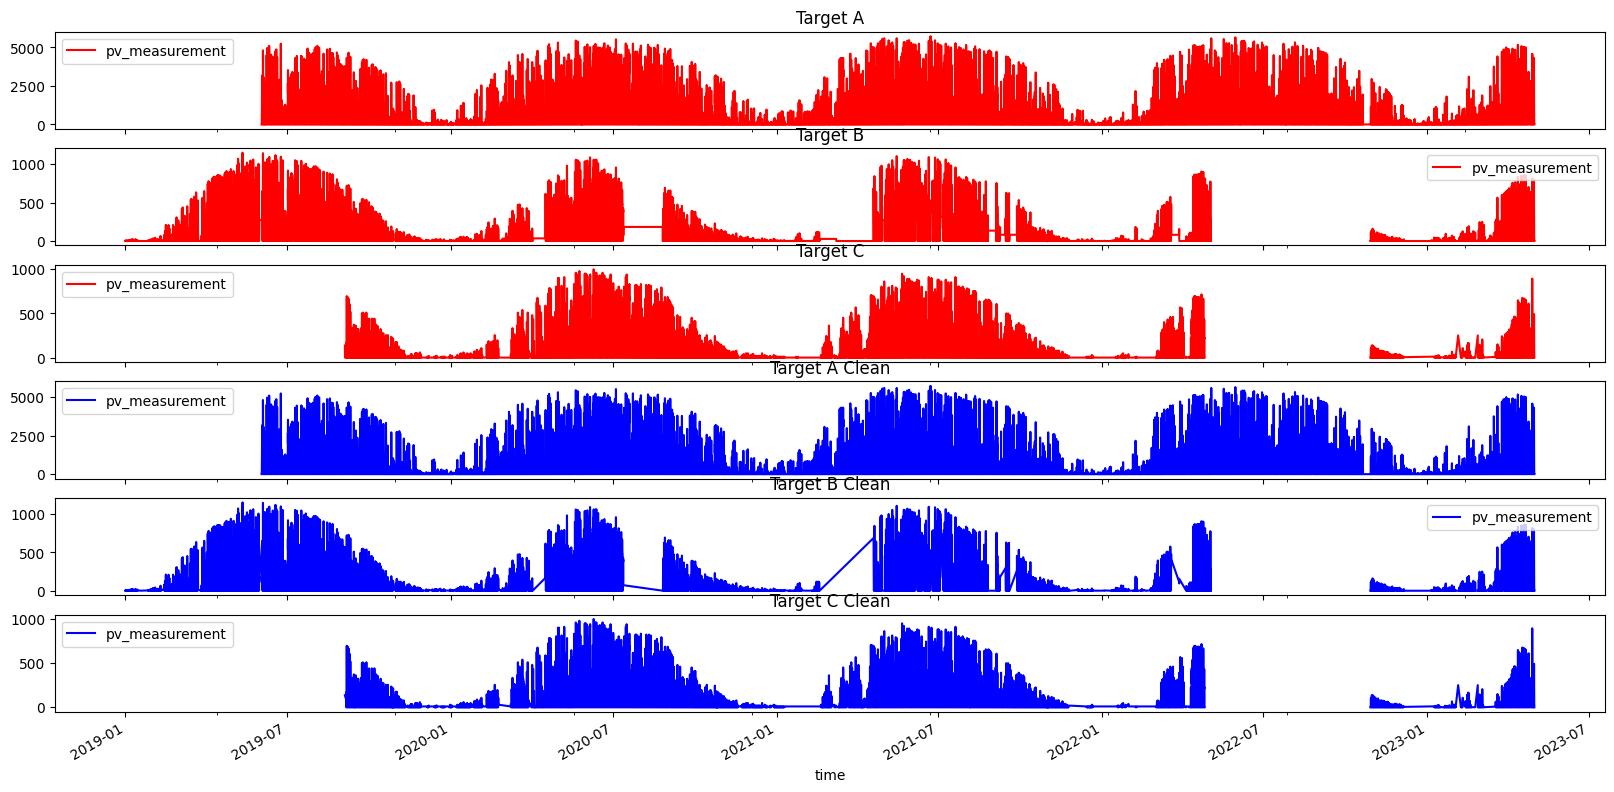

In [12]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
            zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [13]:
# Making sure that target values line up with x_values

def stocastic_median(x_list):
    s = np.median(x_list)
    return int(s)


def gen_agg(df: pd.DataFrame, agg_type, batch_size: int = 4, merge_on = 'first') -> pd.DataFrame:
    """
    Pass dataframe WITH date_forecast value and choose aggregation type by passing string to 'agg_type'
    """
    agg_func = {col: agg_type for col in df.columns[1:]} # [1:] assumes 'date_forecast' is first
    return df.groupby(df.index // batch_size).agg({**{'date_forecast': merge_on}, **agg_func})

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = gen_agg(categorical, agg_type=stocastic_median, merge_on = 'first')
   mean = gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [14]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34017 34017
x,y:  25715 25715
x,y:  21068 21068


In [15]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,estimation_calc_forecast_difference
34012,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,1.0,44545.0
34013,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,1.0,48145.0
34014,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,1.0,51745.0
34015,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,1.0,55345.0
34016,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,1.0,58945.0


# Feature engineering

### Timeseasonality

In [16]:
from typing import List

## We now need functions for assigning daily and YEARly cycles (described in datanalysis docu on Peter branch)
# plus 2 avoids 0 and negative values but we ignore this here since it allready normalises the data
DAY = 24*60*60
YEAR = (365.2425)*DAY
SHIFT = 0 #possible to shift oscilation to avoid 0 and or negative values.

# Conversion datetime -> unix_time
def get_unixtime(datetime: pd.Series) -> pd.Series:
    unixtime = (datetime - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    return unixtime

# functions for creating seasonality:
def sinus_day(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / DAY)) # since it is seconds since 1.1.1970 we divide by seconds in a DAY to get seasonal changes throughout the dat

def sinus_year(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / YEAR))

def cosinus_day(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / DAY))

def cosinus_year(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / YEAR))

# function for returning two series with the daily cycles (sine and cosine)
def get_daycycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_daytime = unixtime.apply(sinus_day)
    sinus_daytime = sinus_daytime.rename('sinus_day') 
    cosinus_daytime = unixtime.apply(cosinus_day)
    cosinus_daytime = cosinus_daytime.rename('cosinus_day')
    return [sinus_daytime, cosinus_daytime]

# Function for returning two series with the yearly cycles
def get_yearcycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_yeartime = unixtime.apply(sinus_year)
    sinus_yeartime = sinus_yeartime.rename('sinus_year')
    cosinus_yeartime = unixtime.apply(cosinus_year)
    cosinus_yeartime = cosinus_yeartime.rename('cosinus_year')
    return [sinus_yeartime, cosinus_yeartime]

def append_seasonal_columns(df: pd.DataFrame, time_column: str = 'date_forecast') -> pd.DataFrame:
    """
    returns joined Dataframe with seasonal data. Does not drop time_column
    """
    # check that time column exists
    if time_column not in df.columns: 
        raise Exception(f"The timecolumn passed: {time_column}, is not part of the dataset passed.")
    
    if not np.issubdtype(df[time_column], np.datetime64):
        raise Exception(f'Passed timecolumn must be of numpy datetime64. Passed type is {df[time_column].dtype()}')
    
    unixtime = get_unixtime(df[time_column])
    day_sin, day_cos = get_daycycle(unixtime)
    year_sin, year_cos = get_yearcycle(unixtime)
    df = df.join([day_sin, day_cos, year_sin, year_cos])
    
    return df


### One-Hot-Encoding

In [17]:

def one_hot_encode(df: pd.DataFrame, col_list: [str]):
  for col in col_list:
    column_to_encode = df[col]
    df_encoded = pd.get_dummies(column_to_encode, prefix=col) # Convert categorical variable into dummy/indicator variables
    df.drop(col, axis=1, inplace=True)
    df_encoded_binary = df_encoded.astype(int) # Convert to binary from boolean
    df = pd.concat([df, df_encoded_binary], axis=1) # Concatenate dataframes
  return df


### Date forecast columns

In [18]:
def date_forecast_columns(df: pd.DataFrame):

  date_forecast = df['date_forecast']
  
  df['year'] = date_forecast.dt.year
  df['month'] = date_forecast.dt.month
  df['day'] = date_forecast.dt.day
  df['hours'] = date_forecast.dt.hour
  df['day_of_week'] = date_forecast.dt.dayofweek
  df['day_of_year'] = date_forecast.dt.dayofyear
  df['week_of_year'] = date_forecast.dt.isocalendar().week

  return df


In [19]:
print(X_train[0].columns)


Index(['date_forecast', 'dew_or_rime:idx', 'precip_type_5min:idx',
       'is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [20]:

def more_features(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'date_forecast' to datetime and set it as index
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.sort_index(inplace=True)
    print(df.head(10))
    # Now apply the rolling function
    df['max_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').max()
    df['min_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').min()
    df['total_solar_rad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['total_wind_speed_10m'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)**0.5
    df['total_snow_1h'] = df[['fresh_snow_1h:cm', 'snow_melt_10min:mm']].sum(axis=1)
    df['pressure_variation_3h'] = df['sfc_pressure:hPa'].diff(periods=3)

    return df

for i in range(len(X_train)):
    X_train[i] = append_seasonal_columns(X_train[i])
    X_train[i] = date_forecast_columns(X_train[i])


for i in range(len(X_frames_test)):
    X_frames_test[i] = append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = date_forecast_columns(X_frames_test[i])  

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
    X_train[i] = one_hot_encode(X_train[i],OH_columns)
    X_frames_test[i] = one_hot_encode(X_frames_test[i], OH_columns)
    X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
    X_train[i] = more_features(X_train[i])
    X_frames_test[i] = more_features(X_frames_test[i])


                     is_day:idx  is_in_shadow:idx  absolute_humidity_2m:gm3  \
date_forecast                                                                 
2019-06-02 22:00:00           0                 1                     7.700   
2019-06-02 23:00:00           0                 1                     7.700   
2019-06-03 00:00:00           0                 1                     7.875   
2019-06-03 01:00:00           0                 1                     8.425   
2019-06-03 02:00:00           1                 0                     8.950   
2019-06-03 03:00:00           1                 0                     9.250   
2019-06-03 04:00:00           1                 0                     9.525   
2019-06-03 05:00:00           1                 0                     9.700   
2019-06-03 06:00:00           1                 0                     9.550   
2019-06-03 07:00:00           1                 0                     9.450   

                     air_density_2m:kgm3  ceiling_h

# Data cleaning

In [21]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,4096,4383
cloud_base_agl:m,2362,1843,1857
snow_density:kgm3,32877,24842,21010
pressure_variation_3h,3,3,3


In [22]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
pressure_variation_3h,3,3,3


In [23]:
print(X_train[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'estimate

In [24]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)




,count,mean,std,min,25%,50%,75%,max
is_day:idx,34017.0,0.486992,0.499838,0.0,0.0,0.0,1.0,1.0
is_in_shadow:idx,34017.0,0.525884,0.499337,0.0,0.0,1.0,1.0,1.0
absolute_humidity_2m:gm3,34017.0,6.324186,2.800683,0.7,4.2,5.825,8.25,17.35
air_density_2m:kgm3,34017.0,1.253254,0.037221,1.145,1.2275,1.2515,1.27725,1.42625
ceiling_height_agl:m,27891.0,2977.367676,2565.257568,27.849998,1128.275024,1981.275024,4177.325195,12294.901367
...,...,...,...,...,...,...,...,...
total_snow_1h,34017.0,0.00754,0.083724,0.0,0.0,0.0,0.0,3.55
pressure_variation_3h,34014.0,0.000786,1.566613,-21.875,-0.800049,0.025024,0.849976,13.199951
msl_pressure:hPa_mean,34017.0,1004.528687,12.68611,939.75,996.612488,1005.474976,1013.331177,1038.943726
diffuse_rad:W_mean,34017.0,47.409863,79.703354,0.0,0.0,1.1,63.887497,386.637512


In [25]:
print(X_frames_test[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'estimate

In [26]:
X_train_ag = [X_train[0].copy(), X_train[1].copy(), X_train[2].copy()]
X_frames_test_ag = [X_frames_test[0].copy(), X_frames_test[1].copy(), X_frames_test[2].copy()]


In [27]:
def multiply_columns(A: pd.Series, B: pd.Series) -> pd.Series:
    '''
    Given two pandas series, returns a series with multiplied values. 

    NB! Series A and B must be of same length
    '''

    if len(A) != len(B): 
        raise Exception("In multiply columns -> length of series is not equal")
    
    C = A*B

    return C


In [28]:
## Multiplying effective cloud coverage with clear sky radiation

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train_ag[i]['clear_sky_rad:W']
    AT = X_frames_test_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test_ag[i]['clear_sky_rad:W']

    X_train_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])


In [29]:
from math import sin, radians

def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train_ag[i]['air_density_2m:kgm3']
    AT = X_frames_test_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test_ag[i]['air_density_2m:kgm3']

    X_train_ag[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)


In [30]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['ceiling_height_agl:m'] = X_frames_test_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['ceiling_height_agl:m']= X_train_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)


In [31]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['cloud_base_agl:m'] = X_frames_test_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['cloud_base_agl:m']= X_train_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)


In [32]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train_ag)):
    X_train_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [33]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [34]:
print(X_train_ag[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_day', 'co

# Training the model

### Catboost

In [35]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])


0:	learn: 1129.8808097	total: 78.4ms	remaining: 1m 18s
1:	learn: 1094.6855691	total: 93.6ms	remaining: 46.7s
2:	learn: 1060.8615167	total: 111ms	remaining: 36.8s
3:	learn: 1028.2402807	total: 123ms	remaining: 30.7s
4:	learn: 997.7289423	total: 140ms	remaining: 27.9s
5:	learn: 968.2895321	total: 153ms	remaining: 25.4s
6:	learn: 940.4665009	total: 169ms	remaining: 24s
7:	learn: 913.6282429	total: 183ms	remaining: 22.7s
8:	learn: 888.0770208	total: 199ms	remaining: 21.9s
9:	learn: 863.1856900	total: 212ms	remaining: 21s
10:	learn: 839.7645581	total: 229ms	remaining: 20.6s
11:	learn: 817.2752952	total: 242ms	remaining: 20s
12:	learn: 795.9304923	total: 255ms	remaining: 19.4s
13:	learn: 775.8564040	total: 271ms	remaining: 19.1s
14:	learn: 756.9498807	total: 284ms	remaining: 18.7s
15:	learn: 738.7458553	total: 301ms	remaining: 18.5s
16:	learn: 721.6413193	total: 313ms	remaining: 18.1s
17:	learn: 705.3510928	total: 326ms	remaining: 17.8s
18:	learn: 689.9628353	total: 343ms	remaining: 17.7s
19

In [36]:
print(Y_train[0].head())


0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64


### AutoGluon

In [37]:
from autogluon.tabular import TabularDataset, TabularPredictor

print(Y_train[0].head(10))

for i in range(len(X_train_ag)):
    X_train_ag[i].reset_index(drop=False, inplace=True)

joined_a = pd.merge(X_train_ag[0], Y_train[0], left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor_a = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, presets='best_quality', time_limit=7200) #, presets='good_quality', time_limit=3600)


/Users/hansstem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20231111_134543/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels/ag-20231111_134543/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   349.52 GB / 494.38 GB (70.7%)
Train Data Rows:    34017
Train Data Columns: 73
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your predi

0       0.00
1       0.00
2       0.00
3       0.00
4      19.36
5     251.02
6     263.78
7     522.72
8     904.42
9    1238.82
Name: pv_measurement, dtype: float64


	Useless Original Features (Count: 1): ['snow_drift:idx']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 2): ['week_of_year', 'precip_type_5min:idx_5']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('UInt32', []) : 1 | ['week_of_year']
		('int', [])    : 1 | ['precip_type_5min:idx_5']
	Types of features in original data (raw dtype, special dtypes):
		('datetime', []) :  1 | ['date_forecast']
		('float', [])    : 54 | ['absolute_humidity_2m:gm3', 'ceiling_height

[1000]	valid_set's l1: 167.852
[2000]	valid_set's l1: 160.652
[3000]	valid_set's l1: 157.402
[4000]	valid_set's l1: 155.087
[5000]	valid_set's l1: 153.576
[6000]	valid_set's l1: 152.642
[7000]	valid_set's l1: 151.939
[8000]	valid_set's l1: 151.412
[9000]	valid_set's l1: 151.09
[10000]	valid_set's l1: 150.778
[1000]	valid_set's l1: 160.048
[2000]	valid_set's l1: 152.256
[3000]	valid_set's l1: 148.74
[4000]	valid_set's l1: 146.228
[5000]	valid_set's l1: 144.665
[6000]	valid_set's l1: 143.661
[7000]	valid_set's l1: 142.964
[8000]	valid_set's l1: 142.584
[9000]	valid_set's l1: 142.195
[10000]	valid_set's l1: 141.805
[1000]	valid_set's l1: 154.161
[2000]	valid_set's l1: 146.028
[3000]	valid_set's l1: 142.362
[4000]	valid_set's l1: 140.329
[5000]	valid_set's l1: 138.774
[6000]	valid_set's l1: 137.712
[7000]	valid_set's l1: 136.915
[8000]	valid_set's l1: 136.399
[9000]	valid_set's l1: 136.083
[10000]	valid_set's l1: 135.84
[1000]	valid_set's l1: 155.37
[2000]	valid_set's l1: 146.756
[3000]	va

	-141.864	 = Validation score   (-mean_absolute_error)
	270.8s	 = Training   runtime
	4.41s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4517.82s of the 6918.81s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 167.217
[2000]	valid_set's l1: 164.204
[3000]	valid_set's l1: 163.031
[4000]	valid_set's l1: 162.575
[5000]	valid_set's l1: 162.16
[6000]	valid_set's l1: 161.848
[7000]	valid_set's l1: 161.673
[8000]	valid_set's l1: 161.535
[9000]	valid_set's l1: 161.437
[10000]	valid_set's l1: 161.378
[1000]	valid_set's l1: 161.132
[2000]	valid_set's l1: 157.138
[3000]	valid_set's l1: 155.755
[4000]	valid_set's l1: 155.076
[5000]	valid_set's l1: 154.704
[6000]	valid_set's l1: 154.462
[7000]	valid_set's l1: 154.365
[8000]	valid_set's l1: 154.266
[9000]	valid_set's l1: 154.189
[10000]	valid_set's l1: 154.13
[1000]	valid_set's l1: 153.17
[2000]	valid_set's l1: 149.575
[3000]	valid_set's l1: 147.983
[4000]	valid_set's l1: 147.532
[5000]	valid_set's l1: 147.356
[6000]	valid_set's l1: 147.23
[7000]	valid_set's l1: 147.091
[8000]	valid_set's l1: 146.96
[9000]	valid_set's l1: 146.906
[10000]	valid_set's l1: 146.869
[1000]	valid_set's l1: 155.882
[2000]	valid_set's l1: 151.867
[3000]	val

	-153.3597	 = Validation score   (-mean_absolute_error)
	291.05s	 = Training   runtime
	4.47s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4220.22s of the 6621.21s of remaining time.
	-175.7368	 = Validation score   (-mean_absolute_error)
	36.01s	 = Training   runtime
	0.77s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4183.22s of the 6584.21s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-159.124	 = Validation score   (-mean_absolute_error)
	630.43s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 3552.57s of the 5953.56s of remaining time.
	-177.94	 = Validation score   (-mean_absolute_error)
	6.65s	 = Training   runtime
	0.76s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3544.94s of the 5945.93s of remaining time.
	Fitting 8 child mo

[1000]	valid_set's l1: 159.04
[2000]	valid_set's l1: 157.683
[3000]	valid_set's l1: 157.323
[4000]	valid_set's l1: 157.215
[5000]	valid_set's l1: 157.175
[6000]	valid_set's l1: 157.159
[7000]	valid_set's l1: 157.153
[8000]	valid_set's l1: 157.151
[9000]	valid_set's l1: 157.149
[10000]	valid_set's l1: 157.149
[1000]	valid_set's l1: 154.437
[2000]	valid_set's l1: 152.649
[3000]	valid_set's l1: 152.246
[4000]	valid_set's l1: 152.131
[5000]	valid_set's l1: 152.094
[6000]	valid_set's l1: 152.076
[7000]	valid_set's l1: 152.07
[8000]	valid_set's l1: 152.067
[9000]	valid_set's l1: 152.066
[10000]	valid_set's l1: 152.065
[1000]	valid_set's l1: 149.818
[2000]	valid_set's l1: 148.542
[3000]	valid_set's l1: 148.188
[4000]	valid_set's l1: 148.059
[5000]	valid_set's l1: 148.018
[6000]	valid_set's l1: 148
[7000]	valid_set's l1: 147.997
[8000]	valid_set's l1: 147.995
[9000]	valid_set's l1: 147.994
[10000]	valid_set's l1: 147.993
[1000]	valid_set's l1: 149.871
[2000]	valid_set's l1: 148.253
[3000]	vali

	-151.1237	 = Validation score   (-mean_absolute_error)
	1038.84s	 = Training   runtime
	10.76s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 479.84s of the 4106.5s of remaining time.
	-137.2274	 = Validation score   (-mean_absolute_error)
	0.22s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 4106.27s of the 4106.26s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 126.032


	-125.8359	 = Validation score   (-mean_absolute_error)
	23.04s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 4082.97s of the 4082.96s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-119.6316	 = Validation score   (-mean_absolute_error)
	10.94s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 4071.89s of the 4071.88s of remaining time.
	-118.9166	 = Validation score   (-mean_absolute_error)
	51.64s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 4019.11s of the 4019.11s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-120.7335	 = Validation score   (-mean_absolute_error)
	43.29s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Train

[1000]	valid_set's l1: 120.355
[1000]	valid_set's l1: 127.294


	-124.7153	 = Validation score   (-mean_absolute_error)
	50.99s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 3665.51s of the 3665.5s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
	-119.1031	 = Validation score   (-mean_absolute_error)
	22.45s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3653.88s of the 3653.87s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
	-119.4161	 = Validation score   (-mean_absolute_error)
	102.76s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 3594.33s of the 3594.32s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
	-112.7781	 = Validation score   (-mean_absolute_error)
	202.78s	 = Trai

[1000]	valid_set's l1: 125.602


	-124.1177	 = Validation score   (-mean_absolute_error)
	145.74s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2252.23s of the 2252.22s of remaining time.
	Fitting 8 child models (S6F1 - S6F8) | Fitting with SequentialLocalFoldFittingStrategy
	-118.4826	 = Validation score   (-mean_absolute_error)
	73.63s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2239.77s of the 2239.77s of remaining time.
	Fitting 8 child models (S6F1 - S6F8) | Fitting with SequentialLocalFoldFittingStrategy
	-118.9892	 = Validation score   (-mean_absolute_error)
	255.75s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 2202.07s of the 2202.07s of remaining time.
	Fitting 8 child models (S6F1 - S6F8) | Fitting with SequentialLocalFoldFittingStrategy
	-111.8006	 = Validation score   (-mean_absolute_error)
	614.78s	 = Tr

[1000]	valid_set's l1: 124.997
[2000]	valid_set's l1: 124.646
[3000]	valid_set's l1: 124.899


	-124.0105	 = Validation score   (-mean_absolute_error)
	220.08s	 = Training   runtime
	1.13s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1182.73s of the 1182.72s of remaining time.
	Fitting 8 child models (S9F1 - S9F8) | Fitting with SequentialLocalFoldFittingStrategy
	-118.4364	 = Validation score   (-mean_absolute_error)
	109.81s	 = Training   runtime
	0.57s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 1170.66s of the 1170.65s of remaining time.
	Fitting 8 child models (S9F1 - S9F8) | Fitting with SequentialLocalFoldFittingStrategy
	-118.9437	 = Validation score   (-mean_absolute_error)
	373.42s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 1128.57s of the 1128.57s of remaining time.
	Fitting 8 child models (S9F1 - S9F8) | Fitting with SequentialLocalFoldFittingStrategy
	-111.7165	 = Validation score   (-mean_absolute_error)
	928.78s	 = T

[1000]	valid_set's l1: 131
[1000]	valid_set's l1: 125.155
[1000]	valid_set's l1: 126.414


	-123.9742	 = Validation score   (-mean_absolute_error)
	246.79s	 = Training   runtime
	1.27s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 829.75s of the 829.74s of remaining time.
	Fitting 8 child models (S10F1 - S10F8) | Fitting with SequentialLocalFoldFittingStrategy
	-118.4397	 = Validation score   (-mean_absolute_error)
	122.15s	 = Training   runtime
	0.64s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 817.26s of the 817.26s of remaining time.
	Fitting 8 child models (S10F1 - S10F8) | Fitting with SequentialLocalFoldFittingStrategy
	-118.9288	 = Validation score   (-mean_absolute_error)
	415.81s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 774.77s of the 774.76s of remaining time.
	Fitting 8 child models (S10F1 - S10F8) | Fitting with SequentialLocalFoldFittingStrategy
	-111.5829	 = Validation score   (-mean_absolute_error)
	1032.25s	 = 

In [38]:
joined_b = pd.merge(X_train_ag[1], Y_train[1], left_index=True, right_index=True)
train_b = TabularDataset(joined_b)
predictor_b = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_b,  presets='best_quality', time_limit=7200)#, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231111_154334/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels/ag-20231111_154334/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   345.17 GB / 494.38 GB (69.8%)
Train Data Rows:    25715
Train Data Columns: 72
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 107.8579, 213.18528)
	If 'regression' is not the correct problem_type, please manually specif

[1000]	valid_set's l1: 22.3719
[2000]	valid_set's l1: 21.4777
[3000]	valid_set's l1: 21.0909
[4000]	valid_set's l1: 20.8582
[5000]	valid_set's l1: 20.7236
[6000]	valid_set's l1: 20.6283
[7000]	valid_set's l1: 20.5469
[8000]	valid_set's l1: 20.4853
[9000]	valid_set's l1: 20.4382
[10000]	valid_set's l1: 20.4086
[1000]	valid_set's l1: 23.0712
[2000]	valid_set's l1: 22.009
[3000]	valid_set's l1: 21.5344
[4000]	valid_set's l1: 21.2928
[5000]	valid_set's l1: 21.1387
[6000]	valid_set's l1: 21.0343
[7000]	valid_set's l1: 20.9759
[8000]	valid_set's l1: 20.9124
[9000]	valid_set's l1: 20.8648
[10000]	valid_set's l1: 20.835
[1000]	valid_set's l1: 22.5893
[2000]	valid_set's l1: 21.5764
[3000]	valid_set's l1: 21.0974
[4000]	valid_set's l1: 20.8396
[5000]	valid_set's l1: 20.6706
[6000]	valid_set's l1: 20.5727
[7000]	valid_set's l1: 20.4958
[8000]	valid_set's l1: 20.4382
[9000]	valid_set's l1: 20.3884
[10000]	valid_set's l1: 20.3638
[1000]	valid_set's l1: 21.5521
[2000]	valid_set's l1: 20.7764
[3000]	

	-20.4302	 = Validation score   (-mean_absolute_error)
	266.68s	 = Training   runtime
	3.61s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4524.53s of the 6925.58s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 22.8031
[2000]	valid_set's l1: 22.3928
[3000]	valid_set's l1: 22.3231
[4000]	valid_set's l1: 22.2402
[5000]	valid_set's l1: 22.1865
[6000]	valid_set's l1: 22.155
[7000]	valid_set's l1: 22.1406
[8000]	valid_set's l1: 22.1329
[9000]	valid_set's l1: 22.1256
[10000]	valid_set's l1: 22.1204
[1000]	valid_set's l1: 23.6361
[2000]	valid_set's l1: 23.1619
[3000]	valid_set's l1: 22.9906
[4000]	valid_set's l1: 22.9285
[5000]	valid_set's l1: 22.8945
[6000]	valid_set's l1: 22.8657
[7000]	valid_set's l1: 22.8447
[8000]	valid_set's l1: 22.836
[9000]	valid_set's l1: 22.8273
[10000]	valid_set's l1: 22.8234
[1000]	valid_set's l1: 23.1948
[2000]	valid_set's l1: 22.7697
[3000]	valid_set's l1: 22.5934
[4000]	valid_set's l1: 22.5288
[5000]	valid_set's l1: 22.4992
[6000]	valid_set's l1: 22.4729
[7000]	valid_set's l1: 22.4662
[8000]	valid_set's l1: 22.4587
[9000]	valid_set's l1: 22.4546
[10000]	valid_set's l1: 22.452
[1000]	valid_set's l1: 21.909
[2000]	valid_set's l1: 21.3986
[3000]	va

	-22.4501	 = Validation score   (-mean_absolute_error)
	267.42s	 = Training   runtime
	3.87s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4251.15s of the 6652.19s of remaining time.
	-25.6243	 = Validation score   (-mean_absolute_error)
	28.57s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4221.91s of the 6622.96s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-22.7454	 = Validation score   (-mean_absolute_error)
	588.89s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 3632.85s of the 6033.89s of remaining time.
	-25.5953	 = Validation score   (-mean_absolute_error)
	4.97s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3627.2s of the 6028.24s of remaining time.
	Fitting 8 child mode

[1000]	valid_set's l1: 22.0387
[2000]	valid_set's l1: 21.9057
[3000]	valid_set's l1: 21.8841
[4000]	valid_set's l1: 21.8779
[5000]	valid_set's l1: 21.8761
[6000]	valid_set's l1: 21.8754
[7000]	valid_set's l1: 21.8752
[8000]	valid_set's l1: 21.875
[9000]	valid_set's l1: 21.875
[10000]	valid_set's l1: 21.875
[1000]	valid_set's l1: 22.7951
[2000]	valid_set's l1: 22.6524
[3000]	valid_set's l1: 22.6268
[4000]	valid_set's l1: 22.6184
[5000]	valid_set's l1: 22.6164
[6000]	valid_set's l1: 22.6156
[7000]	valid_set's l1: 22.6152
[8000]	valid_set's l1: 22.6152
[9000]	valid_set's l1: 22.6152
[10000]	valid_set's l1: 22.6151
[1000]	valid_set's l1: 21.8148
[2000]	valid_set's l1: 21.6667
[3000]	valid_set's l1: 21.6416
[4000]	valid_set's l1: 21.6355
[5000]	valid_set's l1: 21.6345
[6000]	valid_set's l1: 21.6341
[7000]	valid_set's l1: 21.634
[8000]	valid_set's l1: 21.6339
[9000]	valid_set's l1: 21.6339
[10000]	valid_set's l1: 21.6339
[1000]	valid_set's l1: 20.7952
[2000]	valid_set's l1: 20.6787
[3000]	va

	-21.9636	 = Validation score   (-mean_absolute_error)
	1047.97s	 = Training   runtime
	10.36s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 479.85s of the 4336.03s of remaining time.
	-19.875	 = Validation score   (-mean_absolute_error)
	0.18s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 4335.84s of the 4335.83s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-18.853	 = Validation score   (-mean_absolute_error)
	14.86s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 4320.81s of the 4320.8s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.9693	 = Validation score   (-mean_absolute_error)
	10.05s	 = Training   runtime
	0.05s	 = Valida

[1000]	valid_set's l1: 18.5942
[1000]	valid_set's l1: 19.6291
[1000]	valid_set's l1: 19.6833


	-18.7106	 = Validation score   (-mean_absolute_error)
	57.53s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 3716.58s of the 3716.57s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.8449	 = Validation score   (-mean_absolute_error)
	30.47s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3706.89s of the 3706.88s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.9485	 = Validation score   (-mean_absolute_error)
	122.94s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 3668.22s of the 3668.21s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.7963	 = Validation score   (-mean_absolute_error)
	231.18s	 = Trainin

[1000]	valid_set's l1: 17.7615


	-18.6305	 = Validation score   (-mean_absolute_error)
	94.94s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 3137.86s of the 3137.86s of remaining time.
	Fitting 8 child models (S5F1 - S5F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.8193	 = Validation score   (-mean_absolute_error)
	50.59s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3127.72s of the 3127.71s of remaining time.
	Fitting 8 child models (S5F1 - S5F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.8463	 = Validation score   (-mean_absolute_error)
	217.61s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 3085.45s of the 3085.44s of remaining time.
	Fitting 8 child models (S5F1 - S5F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.7317	 = Validation score   (-mean_absolute_error)
	387.96s	 = Trainin

[1000]	valid_set's l1: 19.4501


	-18.6041	 = Validation score   (-mean_absolute_error)
	115.06s	 = Training   runtime
	0.62s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2851.8s of the 2851.8s of remaining time.
	Fitting 8 child models (S6F1 - S6F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.8045	 = Validation score   (-mean_absolute_error)
	61.19s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2841.1s of the 2841.09s of remaining time.
	Fitting 8 child models (S6F1 - S6F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.8325	 = Validation score   (-mean_absolute_error)
	263.29s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 2795.34s of the 2795.34s of remaining time.
	Fitting 8 child models (S6F1 - S6F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.6957	 = Validation score   (-mean_absolute_error)
	465.03s	 = Training 

[1000]	valid_set's l1: 19.675
[1000]	valid_set's l1: 18.3453


	-18.6016	 = Validation score   (-mean_absolute_error)
	133.89s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2553.74s of the 2553.73s of remaining time.
	Fitting 8 child models (S7F1 - S7F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7982	 = Validation score   (-mean_absolute_error)
	71.39s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2543.42s of the 2543.42s of remaining time.
	Fitting 8 child models (S7F1 - S7F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.8205	 = Validation score   (-mean_absolute_error)
	308.97s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 2497.66s of the 2497.66s of remaining time.
	Fitting 8 child models (S7F1 - S7F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.6917	 = Validation score   (-mean_absolute_error)
	540.99s	 = Trainin

[1000]	valid_set's l1: 18.8874


	-18.6084	 = Validation score   (-mean_absolute_error)
	202.0s	 = Training   runtime
	1.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1389.21s of the 1389.21s of remaining time.
	Fitting 8 child models (S11F1 - S11F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7792	 = Validation score   (-mean_absolute_error)
	111.94s	 = Training   runtime
	0.57s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 1378.13s of the 1378.12s of remaining time.
	Fitting 8 child models (S11F1 - S11F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7999	 = Validation score   (-mean_absolute_error)
	491.95s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 1323.02s of the 1323.01s of remaining time.
	Fitting 8 child models (S11F1 - S11F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.6415	 = Validation score   (-mean_absolute_error)
	851.48s	 = 

[1000]	valid_set's l1: 18.9509
[1000]	valid_set's l1: 18.3774


	-18.5944	 = Validation score   (-mean_absolute_error)
	223.09s	 = Training   runtime
	1.2s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1089.62s of the 1089.61s of remaining time.
	Fitting 8 child models (S12F1 - S12F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7718	 = Validation score   (-mean_absolute_error)
	122.99s	 = Training   runtime
	0.63s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 1078.45s of the 1078.44s of remaining time.
	Fitting 8 child models (S12F1 - S12F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7957	 = Validation score   (-mean_absolute_error)
	542.2s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 1028.12s of the 1028.11s of remaining time.
	Fitting 8 child models (S12F1 - S12F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.6356	 = Validation score   (-mean_absolute_error)
	928.25s	 = T

[1000]	valid_set's l1: 18.4732


	-18.5929	 = Validation score   (-mean_absolute_error)
	240.18s	 = Training   runtime
	1.29s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 801.67s of the 801.67s of remaining time.
	Fitting 8 child models (S13F1 - S13F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7746	 = Validation score   (-mean_absolute_error)
	134.03s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 790.5s of the 790.49s of remaining time.
	Fitting 8 child models (S13F1 - S13F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7903	 = Validation score   (-mean_absolute_error)
	589.55s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 743.06s of the 743.06s of remaining time.
	Fitting 8 child models (S13F1 - S13F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.6378	 = Validation score   (-mean_absolute_error)
	1004.35s	 = Train

[1000]	valid_set's l1: 18.7169


	-18.5842	 = Validation score   (-mean_absolute_error)
	259.38s	 = Training   runtime
	1.4s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 514.22s of the 514.22s of remaining time.
	Fitting 8 child models (S14F1 - S14F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7754	 = Validation score   (-mean_absolute_error)
	143.9s	 = Training   runtime
	0.73s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 504.23s of the 504.23s of remaining time.
	Fitting 8 child models (S14F1 - S14F8) | Fitting with SequentialLocalFoldFittingStrategy
	-17.7884	 = Validation score   (-mean_absolute_error)
	630.78s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 462.92s of the 462.92s of remaining time.
	Fitting 8 child models (S14F1 - S14F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.6337	 = Validation score   (-mean_absolute_error)
	1082.16s	 = Traini

In [39]:
joined_c = pd.merge(X_train_ag[2], Y_train[2], left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, presets='best_quality', time_limit=7200)#, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231111_173918/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels/ag-20231111_173918/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   341.16 GB / 494.38 GB (69.0%)
Train Data Rows:    21068
Train Data Columns: 72
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 96.12443, 179.66703)
	If 'regression' is not the correct problem_type, please manually sp

[1000]	valid_set's l1: 20.4776
[2000]	valid_set's l1: 19.7005
[3000]	valid_set's l1: 19.4255
[4000]	valid_set's l1: 19.2351
[5000]	valid_set's l1: 19.1185
[6000]	valid_set's l1: 19.0455
[7000]	valid_set's l1: 18.9941
[8000]	valid_set's l1: 18.9593
[9000]	valid_set's l1: 18.9353
[10000]	valid_set's l1: 18.9261
[1000]	valid_set's l1: 20.0132
[2000]	valid_set's l1: 19.2342
[3000]	valid_set's l1: 18.912
[4000]	valid_set's l1: 18.731
[5000]	valid_set's l1: 18.6325
[6000]	valid_set's l1: 18.5696
[7000]	valid_set's l1: 18.5326
[8000]	valid_set's l1: 18.5106
[9000]	valid_set's l1: 18.4977
[10000]	valid_set's l1: 18.4929
[1000]	valid_set's l1: 20.2893
[2000]	valid_set's l1: 19.4297
[3000]	valid_set's l1: 19.0289
[4000]	valid_set's l1: 18.8526
[5000]	valid_set's l1: 18.7292
[6000]	valid_set's l1: 18.6737
[7000]	valid_set's l1: 18.6377
[8000]	valid_set's l1: 18.6062
[9000]	valid_set's l1: 18.5857
[10000]	valid_set's l1: 18.5718
[1000]	valid_set's l1: 19.6477
[2000]	valid_set's l1: 18.8687
[3000]	

	-18.2055	 = Validation score   (-mean_absolute_error)
	262.3s	 = Training   runtime
	3.06s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4530.05s of the 6931.11s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 21.625
[2000]	valid_set's l1: 21.2629
[3000]	valid_set's l1: 21.2358
[4000]	valid_set's l1: 21.1938
[5000]	valid_set's l1: 21.1655
[6000]	valid_set's l1: 21.149
[7000]	valid_set's l1: 21.1375
[8000]	valid_set's l1: 21.1289
[9000]	valid_set's l1: 21.1255
[10000]	valid_set's l1: 21.1227
[1000]	valid_set's l1: 20.1188
[2000]	valid_set's l1: 19.8771
[3000]	valid_set's l1: 19.7849
[4000]	valid_set's l1: 19.743
[5000]	valid_set's l1: 19.7192
[6000]	valid_set's l1: 19.709
[7000]	valid_set's l1: 19.6984
[8000]	valid_set's l1: 19.6925
[9000]	valid_set's l1: 19.6911
[10000]	valid_set's l1: 19.6892
[1000]	valid_set's l1: 21.7022
[2000]	valid_set's l1: 21.3344
[3000]	valid_set's l1: 21.2059
[4000]	valid_set's l1: 21.1556
[5000]	valid_set's l1: 21.1407
[6000]	valid_set's l1: 21.1319
[7000]	valid_set's l1: 21.1246
[8000]	valid_set's l1: 21.1216
[9000]	valid_set's l1: 21.1192
[10000]	valid_set's l1: 21.1181
[1000]	valid_set's l1: 19.983
[2000]	valid_set's l1: 19.6493
[3000]	val

	-20.0165	 = Validation score   (-mean_absolute_error)
	265.23s	 = Training   runtime
	3.16s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4259.65s of the 6660.7s of remaining time.
	-23.0128	 = Validation score   (-mean_absolute_error)
	20.14s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4238.98s of the 6640.04s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-20.1057	 = Validation score   (-mean_absolute_error)
	569.53s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 3669.3s of the 6070.35s of remaining time.
	-22.8517	 = Validation score   (-mean_absolute_error)
	3.85s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3664.85s of the 6065.9s of remaining time.
	Fitting 8 child models

[1000]	valid_set's l1: 21.3542
[2000]	valid_set's l1: 21.2309
[3000]	valid_set's l1: 21.2124
[4000]	valid_set's l1: 21.2098
[5000]	valid_set's l1: 21.2089
[6000]	valid_set's l1: 21.2087
[7000]	valid_set's l1: 21.2086
[8000]	valid_set's l1: 21.2086
[9000]	valid_set's l1: 21.2086
[10000]	valid_set's l1: 21.2086
[1000]	valid_set's l1: 19.7719
[2000]	valid_set's l1: 19.693
[3000]	valid_set's l1: 19.6793
[4000]	valid_set's l1: 19.6765
[5000]	valid_set's l1: 19.6759
[6000]	valid_set's l1: 19.6758
[7000]	valid_set's l1: 19.6758
[1000]	valid_set's l1: 21.1253
[2000]	valid_set's l1: 21.0186
[3000]	valid_set's l1: 21.0012
[4000]	valid_set's l1: 20.9979
[5000]	valid_set's l1: 20.9971
[6000]	valid_set's l1: 20.9969
[7000]	valid_set's l1: 20.9968
[8000]	valid_set's l1: 20.9967
[9000]	valid_set's l1: 20.9967
[10000]	valid_set's l1: 20.9967
[1000]	valid_set's l1: 19.7108
[2000]	valid_set's l1: 19.6139
[3000]	valid_set's l1: 19.5986
[4000]	valid_set's l1: 19.5962
[5000]	valid_set's l1: 19.5955
[6000]	

	-20.0167	 = Validation score   (-mean_absolute_error)
	995.49s	 = Training   runtime
	7.78s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 479.85s of the 4502.66s of remaining time.
	-17.5238	 = Validation score   (-mean_absolute_error)
	0.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 4502.49s of the 4502.49s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 16.9967


	-16.6954	 = Validation score   (-mean_absolute_error)
	17.51s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 4484.79s of the 4484.78s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.161	 = Validation score   (-mean_absolute_error)
	10.15s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 4474.53s of the 4474.53s of remaining time.
	-15.8413	 = Validation score   (-mean_absolute_error)
	26.98s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 4447.01s of the 4447.01s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.3938	 = Validation score   (-mean_absolute_error)
	38.73s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ... Training m

[1000]	valid_set's l1: 16.7064
[2000]	valid_set's l1: 16.6212
[3000]	valid_set's l1: 16.5979
[4000]	valid_set's l1: 16.5874
[5000]	valid_set's l1: 16.5715
[6000]	valid_set's l1: 16.5432
[7000]	valid_set's l1: 16.5248
[8000]	valid_set's l1: 16.5191
[9000]	valid_set's l1: 16.5089
[10000]	valid_set's l1: 16.4982


	-16.5586	 = Validation score   (-mean_absolute_error)
	78.54s	 = Training   runtime
	0.6s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 3910.38s of the 3910.38s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9696	 = Validation score   (-mean_absolute_error)
	31.01s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 3899.77s of the 3899.77s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.1436	 = Validation score   (-mean_absolute_error)
	122.67s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 3856.7s of the 3856.7s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.1915	 = Validation score   (-mean_absolute_error)
	189.52s	 = Training  

[1000]	valid_set's l1: 15.5456


	-16.5166	 = Validation score   (-mean_absolute_error)
	138.02s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2921.3s of the 2921.29s of remaining time.
	Fitting 8 child models (S7F1 - S7F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9571	 = Validation score   (-mean_absolute_error)
	73.28s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2910.55s of the 2910.54s of remaining time.
	Fitting 8 child models (S7F1 - S7F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.0946	 = Validation score   (-mean_absolute_error)
	266.06s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 2872.31s of the 2872.3s of remaining time.
	Fitting 8 child models (S7F1 - S7F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.1061	 = Validation score   (-mean_absolute_error)
	442.5s	 = Training  

[1000]	valid_set's l1: 15.8937


	-16.5116	 = Validation score   (-mean_absolute_error)
	156.46s	 = Training   runtime
	0.96s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2669.86s of the 2669.86s of remaining time.
	Fitting 8 child models (S8F1 - S8F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9591	 = Validation score   (-mean_absolute_error)
	83.82s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2659.21s of the 2659.2s of remaining time.
	Fitting 8 child models (S8F1 - S8F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.0843	 = Validation score   (-mean_absolute_error)
	312.34s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 2612.85s of the 2612.84s of remaining time.
	Fitting 8 child models (S8F1 - S8F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.1018	 = Validation score   (-mean_absolute_error)
	506.79s	 = Trainin

[1000]	valid_set's l1: 17.7144
[1000]	valid_set's l1: 15.5358


	-16.5016	 = Validation score   (-mean_absolute_error)
	175.32s	 = Training   runtime
	1.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 2412.11s of the 2412.1s of remaining time.
	Fitting 8 child models (S9F1 - S9F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9563	 = Validation score   (-mean_absolute_error)
	94.34s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 2401.49s of the 2401.48s of remaining time.
	Fitting 8 child models (S9F1 - S9F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.0842	 = Validation score   (-mean_absolute_error)
	347.17s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 2366.59s of the 2366.59s of remaining time.
	Fitting 8 child models (S9F1 - S9F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.0953	 = Validation score   (-mean_absolute_error)
	570.88s	 = Trainin

[1000]	valid_set's l1: 17.4495


	-16.4887	 = Validation score   (-mean_absolute_error)
	254.13s	 = Training   runtime
	1.41s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1158.54s of the 1158.54s of remaining time.
	Fitting 8 child models (S14F1 - S14F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9282	 = Validation score   (-mean_absolute_error)
	147.8s	 = Training   runtime
	0.61s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 1147.39s of the 1147.39s of remaining time.
	Fitting 8 child models (S14F1 - S14F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.0692	 = Validation score   (-mean_absolute_error)
	546.54s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 1108.19s of the 1108.18s of remaining time.
	Fitting 8 child models (S14F1 - S14F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.0631	 = Validation score   (-mean_absolute_error)
	890.6s	 = T

[1000]	valid_set's l1: 16.5909
[1000]	valid_set's l1: 15.8798


	-16.4776	 = Validation score   (-mean_absolute_error)
	275.17s	 = Training   runtime
	1.5s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 906.23s of the 906.23s of remaining time.
	Fitting 8 child models (S15F1 - S15F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9294	 = Validation score   (-mean_absolute_error)
	158.13s	 = Training   runtime
	0.65s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 895.8s of the 895.8s of remaining time.
	Fitting 8 child models (S15F1 - S15F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.0588	 = Validation score   (-mean_absolute_error)
	590.97s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 851.29s of the 851.28s of remaining time.
	Fitting 8 child models (S15F1 - S15F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.0568	 = Validation score   (-mean_absolute_error)
	953.89s	 = Training

[1000]	valid_set's l1: 16.2193


	-16.4812	 = Validation score   (-mean_absolute_error)
	291.66s	 = Training   runtime
	1.58s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 644.9s of the 644.89s of remaining time.
	Fitting 8 child models (S16F1 - S16F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.9278	 = Validation score   (-mean_absolute_error)
	168.75s	 = Training   runtime
	0.69s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 634.17s of the 634.16s of remaining time.
	Fitting 8 child models (S16F1 - S16F8) | Fitting with SequentialLocalFoldFittingStrategy
	-16.0628	 = Validation score   (-mean_absolute_error)
	637.2s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 587.87s of the 587.86s of remaining time.
	Fitting 8 child models (S16F1 - S16F8) | Fitting with SequentialLocalFoldFittingStrategy
	-15.0531	 = Validation score   (-mean_absolute_error)
	1017.84s	 = Traini

# Evaluate prediction

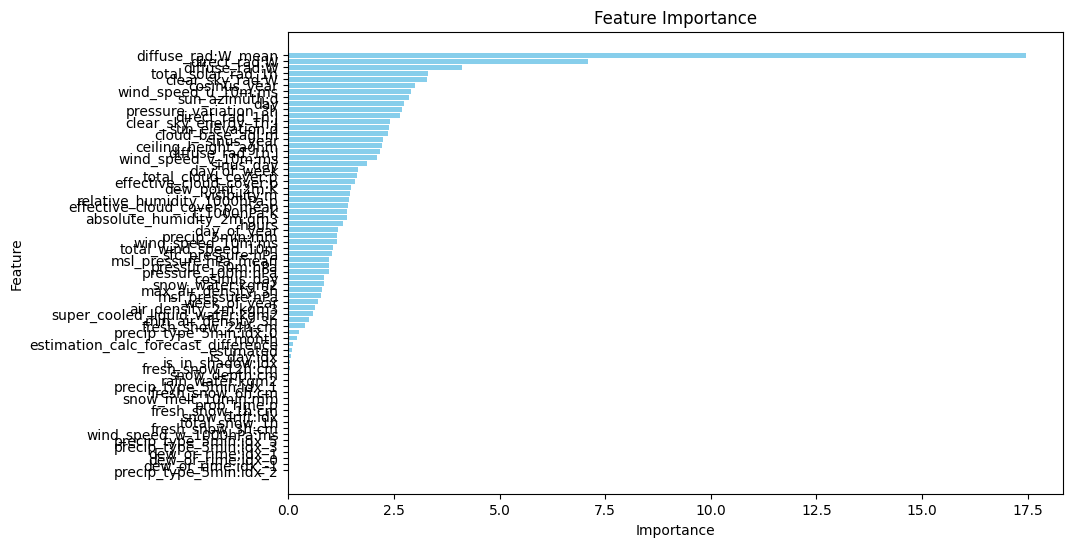

In [40]:
# Feature importance catboost

import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': X_train[0].columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()


In [41]:
# Feature importance autogluon

# import matplotlib.pyplot as plt

# feature_importance = predictor.feature_importance()

# # Create a DataFrame to store feature names and their importance scores
# importance_df = pd.DataFrame({'Feature': X_train_ag[0].columns, 'Importance': feature_importance})

# # Sort the DataFrame by importance scores in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Create a bar plot to visualize feature importance

# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
# plt.show()


# Make predictions

In [44]:
# Train the model on the entire training data

y_pred_cat_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_cat_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_cat_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']


In [49]:
for i in range(len(X_frames_test_ag)):
    X_frames_test_ag[i].reset_index(drop=False, inplace=True)


In [50]:

y_pred_ag_a = predictor_a.predict(X_frames_test_ag[0]) * X_frames_test_ag[0]['is_day:idx']
y_pred_ag_b = predictor_b.predict(X_frames_test_ag[1]) * X_frames_test_ag[1]['is_day:idx']
y_pred_ag_c = predictor_c.predict(X_frames_test_ag[2]) * X_frames_test_ag[2]['is_day:idx']


In [51]:

y_pred_cat = np.concatenate((y_pred_cat_a, y_pred_cat_b, y_pred_cat_c), axis=0)
y_pred_ag = np.concatenate((y_pred_ag_a, y_pred_ag_b, y_pred_ag_c), axis=0)


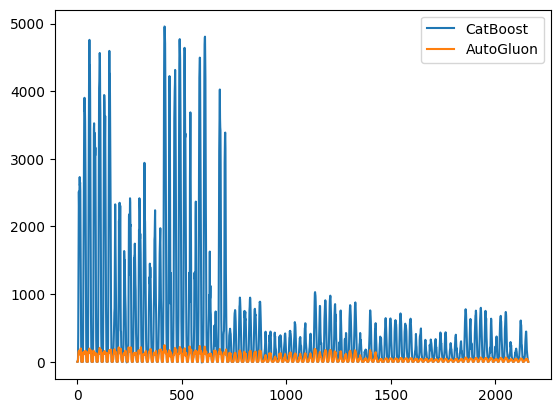

In [61]:
import matplotlib.pyplot as plt

# Plot the predictions
plt.plot(y_pred_cat, label='CatBoost')
plt.plot(y_pred_ag, label='AutoGluon')
plt.legend()
plt.show()


### Combine predictions

In [52]:

mean_of_predictions = (y_pred_cat + y_pred_ag) / 2
y_pred = mean_of_predictions


In [53]:
print(len(y_pred_cat))
print(len(y_pred_ag))


2160
2160


In [54]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0


# Create submission

In [58]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_cat_ag.csv', index=False)


(2160,)
(2160,)


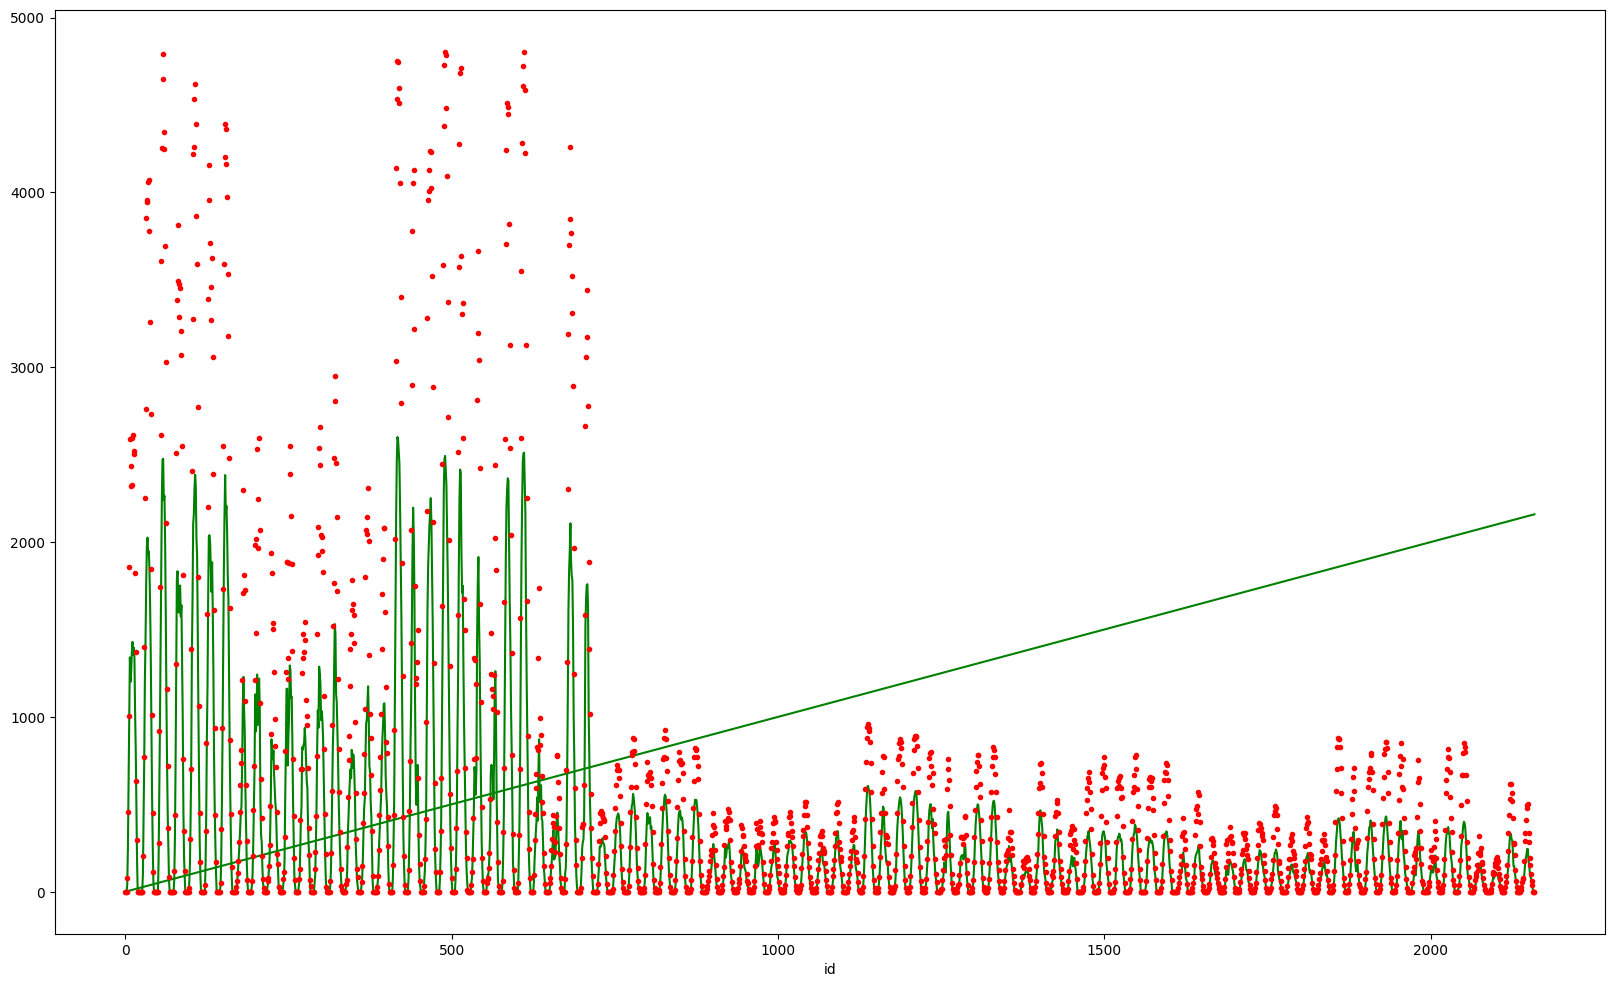

In [59]:
best_submission = pd.read_csv('../model_notebooks/submissions/submission_cat_147SUI.csv')
second_best_sub = pd.read_csv('./submissions/submission_SH1_cat_ag.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub, 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.xlabel("id")
plt.show()


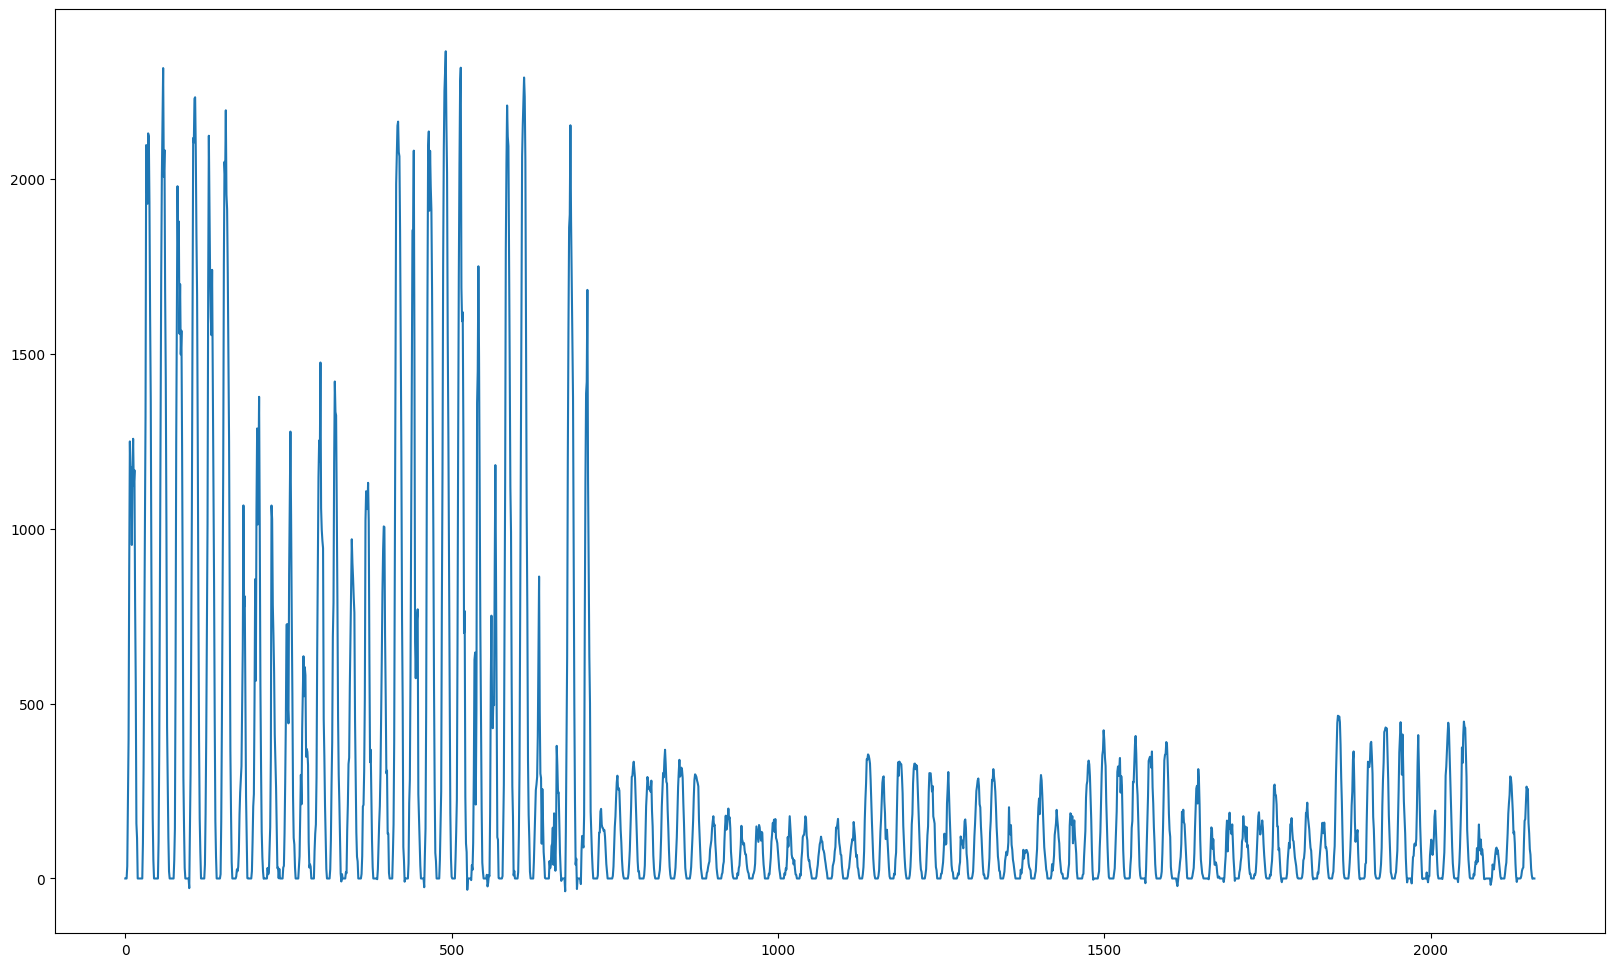

In [60]:
dist = best_submission['prediction'] - second_best_sub['prediction']

plt.figure(figsize=(20,12))
plt.plot(dist)
